<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

#loading
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")
CENTURY = pd.read_csv('https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw3/CENTURY.csv')
CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")
EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")
GILL = pd.read_csv('https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw3/GILL.csv')

#cleaning
drop_names = ["fontVariant","m_label","orientation","m_top","m_left","originalH","originalW","h","w"]
FONT = [BITSTREAMVERA, CENTURY, CONSOLAS, EBRIMA, GILL]; CL = []
for i in range(5):
  CL.append(FONT[i][(FONT[i]['strength']==0.4) & (FONT[i]['italic']==0)].drop(drop_names,axis=1))

#transforming
def fontToMatrix(font, df):
  for case in range(df.shape[0]):
    font[case] =  np.array(df[df.columns[3:]].iloc[case]).reshape(20,20)

FONT_mat = [] #font as 20x20 matrix
for i in range(5):
  FONT_mat.append(np.empty((CL[i].shape[0],20,20), int))
  fontToMatrix(FONT_mat[i], CL[i])

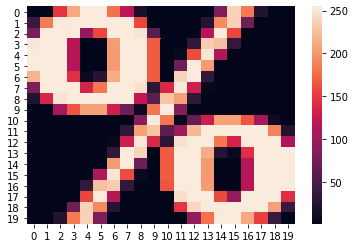

In [22]:
sns.heatmap(FONT_mat[4][870]) #example: Gill, case 871